In [1]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from tqdm import tqdm
import json
import os
import torch
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_json("data_cleaned_opinion.json")
df['date'] = pd.to_datetime(df['date_parsed'], errors='coerce')

In [3]:
df.head()

,url,abstract,full_text,tags,title,author,date_parsed,date
0,https://ukraina.ru/20250529/si-vis-pacem-para-...,"Главный редактор журнала ""Национальная оборона...","Например, когда Германия таки решится и постав...","[ЕС, Украина, Еврокомиссия, война, вооружения,...","""Si vis pacem, para bellum"" от ЕС и ОДКБ. Прот...",Владимир Скачко,2025-06-04T17:19:00.000,2025-06-04 17:19:00
1,https://ukraina.ru/20250529/den-nezavisimosti-...,24 мая президент Турции Реджеп Тайип Эрдоган п...,Общее правило при определении дней независимос...,"[Мнения, Грузия, США, Турция, Дональд Трамп, Э...",День независимости Грузии. Мысленное путешеств...,Василий Стоякин,2025-06-04T15:35:00.000,2025-06-04 15:35:00
2,https://ukraina.ru/20250529/master-klass-mezhd...,Второго июня в Стамбуле запланирован второй ра...,"Дело в том, что подобные делегации, состоящие ...","[Россия, Украина, Москва, Сергей Лавров, Влади...",Мастер-класс между раундами переговоров,Ростислав Ищенко,2025-06-04T10:02:00.000,2025-06-04 10:02:00
3,https://ukraina.ru/20250528/lev-gotovitsya-k-b...,Папа Римский Лев XIV в конце общей аудиенции 2...,Такое предложение – организовать встречу Росси...,"[Ватикан, Украина, Россия, Папа Римский, Влади...",Лев готовится к броску. Папа Римский опять за...,Владимир Скачко,2025-06-03T21:14:00.000,2025-06-03 21:14:00
4,https://ukraina.ru/20250528/insayd-iz-ssha-kto...,После задавших темп в международном кейсе пред...,"Состоялся обмен пленными в три захода, выполне...","[Украина, Россия, Вашингтон, Владимир Зеленски...",Инсайд из США. Кто новый куратор Украины в Ваш...,Михаил Павлив,2025-06-03T19:54:00.000,2025-06-03 19:54:00


In [4]:
def extract_sentences(text, keywords):
    sentences = re.split(r"[.!?…]\s+", text)
    pattern = re.compile("|".join(keywords), flags=re.IGNORECASE)
    return [s.strip() for s in sentences if pattern.search(s)]

keywords = [r"\bнато\b", r"\bсевероатлантическ", r"\bес\b", r"\bевросоюз", r"\bевропейск"]

rows = []
for _, row in df.iterrows():
    for s in extract_sentences(row['full_text'], keywords):
        if len(s) > 20:
            rows.append({'date': row['date'], 'text': s})

df_sentences = pd.DataFrame(rows)
df_sentences['year'] = df_sentences['date'].dt.to_period('Y').astype(str)


In [44]:
sentiment_model = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment", tokenizer="blanchefort/rubert-base-cased-sentiment")

def apply_sentiment(df, batch_size=16):
    texts = df['text'].tolist()
    labels, scores = [], []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        try:
            results = sentiment_model(batch, truncation=True)
            labels.extend([r['label'] for r in results])
            scores.extend([r['score'] for r in results])
        except Exception as e:
            labels.extend(["ERROR"] * len(batch))
            scores.extend([0.0] * len(batch))
    df['label'] = labels
    df['score'] = scores
    return df

df_sentences = apply_sentiment(df_sentences)
df_sentences = df_sentences[df_sentences['label'].isin(['POSITIVE', 'NEUTRAL', 'NEGATIVE'])]


Device set to use cuda:0
100%|██████████| 832/832 [01:31<00:00,  9.14it/s]


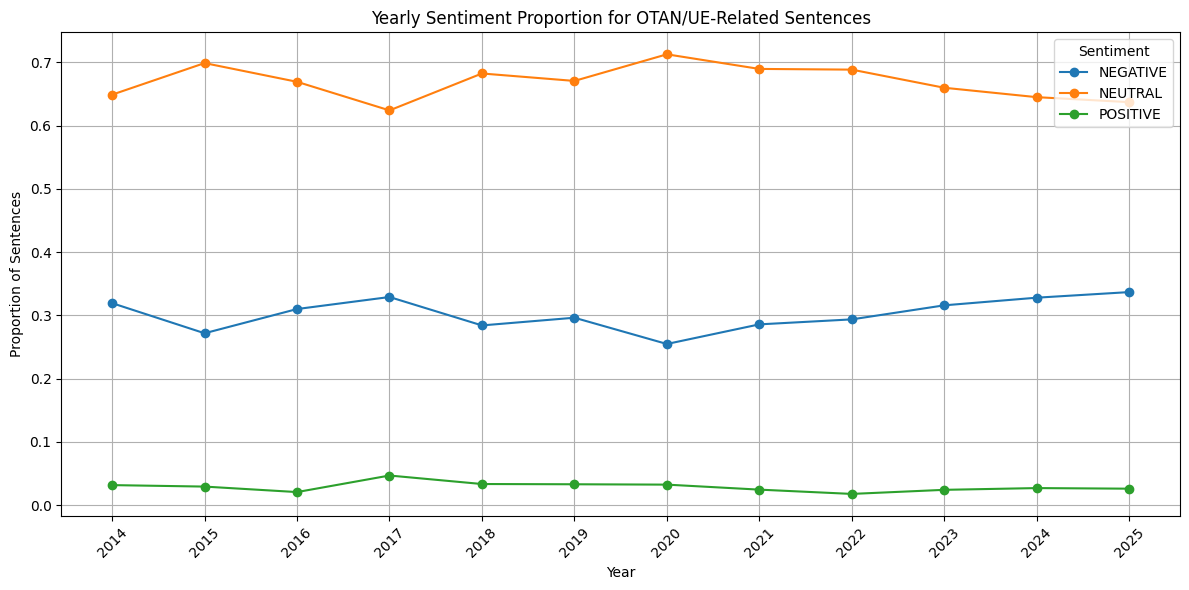

In [ ]:
sentiment_by_year = df_sentences.groupby(['year', 'label']).size().unstack(fill_value=0)
sentiment_pct = sentiment_by_year.div(sentiment_by_year.sum(axis=1), axis=0)

# Affichage
plt.figure(figsize=(12, 6))
for label in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
    if label in sentiment_pct.columns:
        plt.plot(sentiment_pct.index, sentiment_pct[label], label=label, marker='o')

plt.title("Yearly Sentiment Proportion for OTAN/UE-Related Sentences")
plt.xlabel("Year")
plt.ylabel("Proportion of Sentences")
plt.legend(title="Sentiment")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
with open("data_cleaned_opinion.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df_all = pd.DataFrame(data)
df_all["date_parsed"] = pd.to_datetime(df_all["date_parsed"], errors="coerce")
df_all = df_all.dropna(subset=["date_parsed"])
df_all["date"] = df_all["date_parsed"].dt.date

df_sampled = df_all.groupby("date").apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)
texts = df_sampled["full_text"].tolist()
dates = df_sampled["date_parsed"].tolist()
titles = df_sampled["title"].tolist()


In [6]:
labels = [
    "оправдание российской военной операции",        # Justification militaire
    "представление России как жертвы",               # Victimisation russe
    "отрицание украинской государственности",        # Dénégation ukrainienne
    "нейтральное изложение событий",                 # Neutre
    "проукраинское освещение событий",               # Narration pro-Ukraine
]

device = 0 if torch.cuda.is_available() else -1
model_name = "facebook/bart-large-mnli"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline(
    "zero-shot-classification",
    model=model,
    tokenizer=tokenizer,
    device=device
)


Device set to use cuda:0


In [8]:
chunk_size = 1000
output_file = "ukraina_zero_shot_military.csv"

if os.path.exists(output_file):
    df_prev = pd.read_csv(output_file)
    already_done = set(df_prev["article_id"].tolist())
    results = df_prev.to_dict(orient="records")
    print(f"{len(already_done)} chunks already processed.")
else:
    already_done = set()
    results = []

826 chunks already processed.


In [9]:
def split_text(text, size):
    return [text[i:i+size] for i in range(0, len(text), size)]

for idx, (text, date, title) in tqdm(enumerate(zip(texts, dates, titles)), total=len(texts)):
    chunks = split_text(text, chunk_size)
    for i, chunk in enumerate(chunks):
        chunk_id = f"article_{idx}_{i+1}"
        if chunk_id in already_done:
            continue
        try:
            output = classifier(
                chunk,
                candidate_labels=labels,
                hypothesis_template="Этот текст — {}."
            )
            result = {
                "article_id": chunk_id,
                "title": title,
                "date_parsed": date,
                "text_snippet": chunk[:1000]
            }
            for label, score in zip(output["labels"], output["scores"]):
                result[label] = score
            results.append(result)
        except Exception as e:
            print(f"Error with {chunk_id}: {e}")
            continue

    if idx % 100 == 0:
        pd.DataFrame(results).to_csv(output_file, index=False)

100%|██████████| 2901/2901 [5:24:45<00:00,  6.72s/it]  


In [10]:
df_scores = pd.read_csv("ukraina_zero_shot_military.csv")
global_means = df_scores[labels].mean().sort_values(ascending=False)
print("Proportion moyenne des scores par classe :")
print(global_means)

Proportion moyenne des scores par classe :
проукраинское освещение событий           0.234074
отрицание украинской государственности    0.201176
нейтральное изложение событий             0.199257
представление России как жертвы           0.184847
оправдание российской военной операции    0.180646
dtype: float64


In [11]:
df_scores['date_parsed'] = pd.to_datetime(df_scores['date_parsed'], errors='coerce')
df_scores['month'] = df_scores['date_parsed'].dt.to_period('M').astype(str)
monthly_scores = df_scores.groupby('month')[labels].mean()

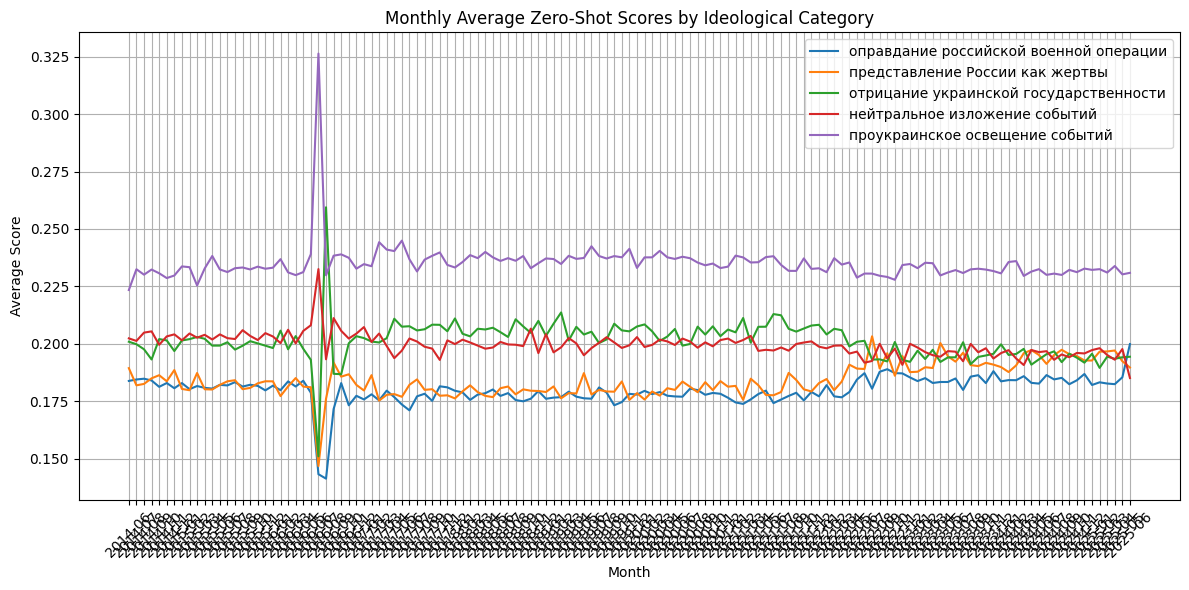

In [12]:
plt.figure(figsize=(12, 6))
for label in labels:
    plt.plot(monthly_scores.index, monthly_scores[label], label=label)

plt.title("Monthly Average Zero-Shot Scores by Ideological Category")
plt.xlabel("Month")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()